In [ ]:
!rm -rf *
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!mkdir data
!cp /content/gdrive/MyDrive/CZ4041Data/dog-breed-identification.zip /content/data


In [ ]:
!kaggle

In [ ]:
!cp /content/gdrive/MyDrive/CZ4041Data/kaggle.json  ~/.kaggle/


In [ ]:
!unzip /content/data/dog-breed-identification.zip -d /content/data

In [ ]:
#Importing required libraries

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img

from collections import Counter

import tensorflow_hub as hub


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [ ]:
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#reading labels csv file

labels = pd.read_csv('/content/data/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#describe
labels.describe()


,id,breed
count,10222,10222
unique,10222,120
top,c648c75a66ac06d71242e46e628ad3cc,scottish_deerhound
freq,1,126


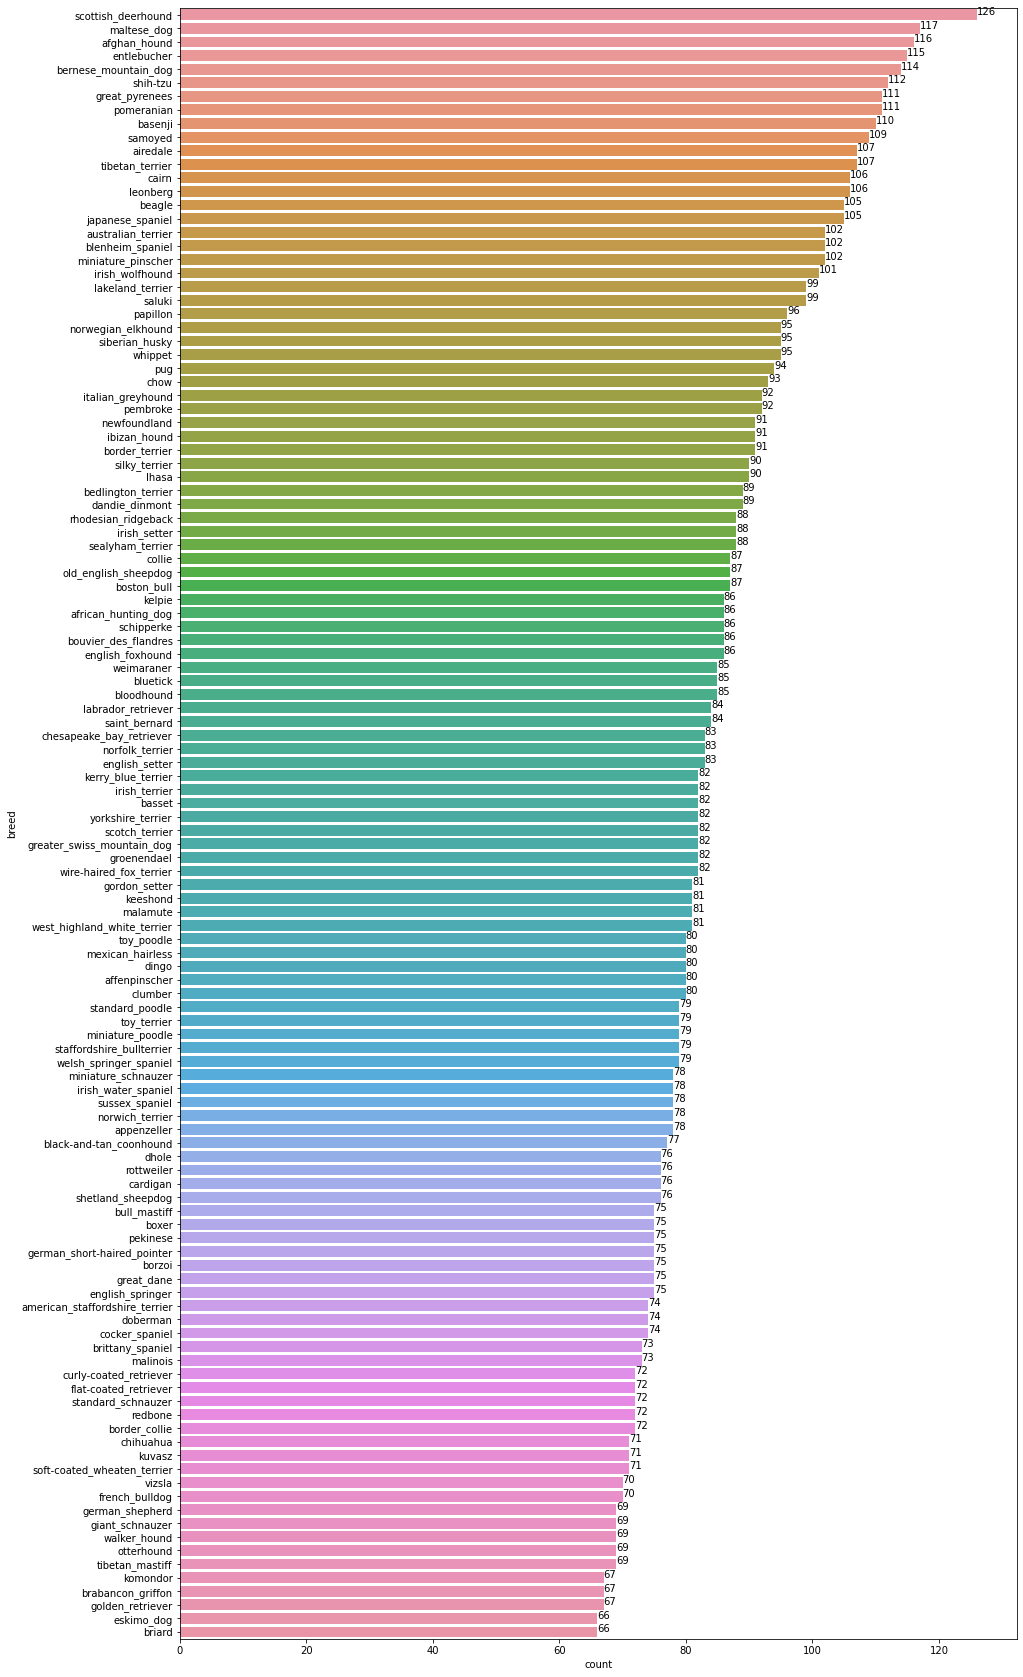

In [ ]:
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

In [ ]:
import os
if len(os.listdir('/content/data/train/')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


# Class Weights information

Using information of the classdistribtion, we create class weights for the classes for inbalanced data training used later

In [ ]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
breed = labels.sort_values(by=['breed'])
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(breed['breed']),
                                                 breed['breed'])
class_weights = list(class_weights)
class_weights = dict(zip(range(n_classes), class_weights))
class_weights

{0: 1.0647916666666666,
 1: 0.7343390804597701,
 2: 0.9905038759689923,
 3: 0.7961059190031152,
 4: 1.151126126126126,
 5: 1.092094017094017,
 6: 0.8351307189542484,
 7: 0.7743939393939394,
 8: 1.0388211382113821,
 9: 0.8112698412698413,
 10: 0.9571161048689139,
 11: 0.7472222222222222,
 12: 1.1062770562770563,
 13: 0.8351307189542484,
 14: 1.002156862745098,
 15: 1.002156862745098,
 16: 1.183101851851852,
 17: 0.9360805860805861,
 18: 1.1357777777777778,
 19: 0.9791187739463602,
 20: 0.9905038759689923,
 21: 1.1357777777777778,
 22: 1.2713930348258706,
 23: 1.2906565656565656,
 24: 1.1668949771689499,
 25: 1.1357777777777778,
 26: 0.8036163522012578,
 27: 1.1208333333333333,
 28: 1.0263052208835342,
 29: 1.1997652582159624,
 30: 0.9159498207885305,
 31: 1.0647916666666666,
 32: 1.151126126126126,
 33: 0.9791187739463602,
 34: 1.183101851851852,
 35: 0.9571161048689139,
 36: 1.1208333333333333,
 37: 1.0647916666666666,
 38: 1.151126126126126,
 39: 0.9905038759689923,
 40: 1.02630522088

# Loading images into numpy array format

In [ ]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#        img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y


In [ ]:
import time 
t = time.time()

X_data,y = images_to_array('/content/data/train', labels[:])


print('runtime in seconds: {}'.format(time.time() - t))


runtime in seconds: 39.7909197807312


In [ ]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/content/data/test/')


Ouptut Data Size:  (10357, 331, 331, 3)


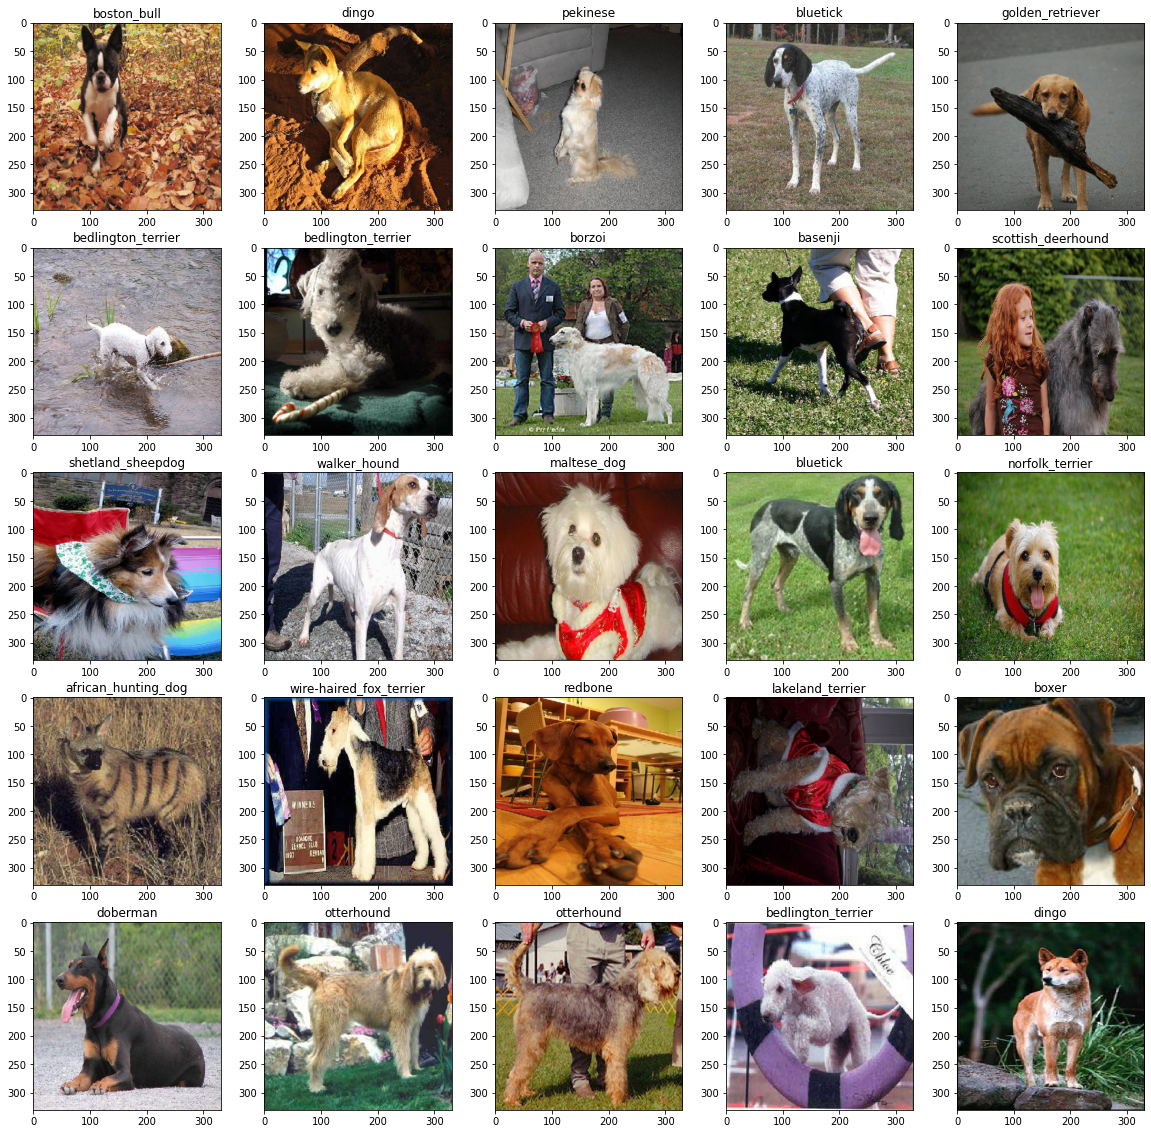

In [ ]:
# lets check some dogs and their breeds
n=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X_data[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image

In [ ]:
# Hyperparameters
batch_size= 128
# epochs=100
# learn_rate=.0001
# sgd=SGD(lr=learn_rate,momentum=.9,nesterov=True)
# adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Helper functions to load pre-trained models

In [ ]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)
input_layer = Input(img_size)

def get_features(model_name, model_preprocessor, input_size):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)
    base_model.trainable = False
    model_out = base_model(preprocessor)
    avg = GlobalAveragePooling2D()(model_out)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    return feature_extractor


def get_features_hub(hub_url, input_size):
    input_layer = Input(input_size)
    module = hub.KerasLayer(hub_url)
    out = module(input_layer) 
    feature_extractor = Model(inputs = input_layer, outputs = out)
    return feature_extractor

In [ ]:
feature_extractors = []

In [ ]:
# Extract features using InceptionV3 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size)

feature_extractors.append(inception_features)

In [ ]:
# Extract features using Xception 
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size)

feature_extractors.append(xception_features)

In [ ]:
# Extract features using InceptionResNetV2 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size)

feature_extractors.append(inc_resnet_features)

In [ ]:
# Extract features using NASNetLarge 
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size)

feature_extractors.append(nasnet_features)

In [ ]:
bitm_features = get_features_hub("https://tfhub.dev/google/bit/s-r101x3/1", img_size)
feature_extractors.append(bitm_features)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def get_training_callbacks():
    #Learning Rate Annealer
  #reduce learning rate by factor of 0.01 whenever no improvement on loss
  lrr= ReduceLROnPlateau(monitor='val_loss', factor=.01, patience=3, min_lr=1e-5,verbose = 0)

  #Prepare call backs
  #training will stop as soon as val_loss is no longer decreasing
  EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

  return lrr, EarlyStop

In [ ]:
def get_model(input_size, dropout, lr):
  model = Sequential()
  model.add(Input(shape=(input_size,)))
  model.add(Dropout(dropout,input_shape=(input_size,)))
  model.add(Dense(n_classes))
  adam=Adam(lr=lr)
  model.compile(optimizer=adam,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold


# Experiments for individual pre-trained models as feature extractor

In [ ]:
X_bitm = bitm_features.predict(X_data)

kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X_bitm, y.argmax(1)):
  train_x_s, val_x_s = X_bitm[train_index], X_bitm[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_ds = prepare(train_ds, shuffle=True)
  val_ds = prepare(val_ds)


  model = get_model(train_x_s.shape[1], 0.5, 0.0001)
  lrr, EarlyStop = get_training_callbacks()
  history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=500,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose=0)
  
  losses.append(model.evaluate(val_ds,verbose=0)[0])
loss = sum(losses)/len(losses)

print("Best val loss for bitm: {}".format(loss))


Best val loss for bitm: 0.27787835001945493


In [ ]:
X_inception = inception_features.predict(X_data)

kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X_inception, y.argmax(1)):
  train_x_s, val_x_s = X_inception[train_index], X_inception[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_ds = prepare(train_ds, shuffle=True)
  val_ds = prepare(val_ds)


  model = get_model(train_x_s.shape[1], 0.5, 0.0001)
  lrr, EarlyStop = get_training_callbacks()
  history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=500,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose=0)

  losses.append(model.evaluate(val_ds,verbose=0)[0])
loss = sum(losses)/len(losses)

print("Best val loss for inception: {}".format(loss))


Best val loss for inception: 0.26093970239162445


In [ ]:
X_xception = xception_features.predict(X_data)


kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X_xception, y.argmax(1)):
  train_x_s, val_x_s = X_xception[train_index], X_xception[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_ds = prepare(train_ds, shuffle=True)
  val_ds = prepare(val_ds)



  model = get_model(train_x_s.shape[1], 0.5, 0.0001)
  lrr, EarlyStop = get_training_callbacks()
  history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=500,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose=0)
  
  losses.append(model.evaluate(val_ds,verbose=0)[0])
loss = sum(losses)/len(losses)
print("Best val loss for xception: {}".format(loss))


Best val loss for xception: 0.25809344947338103


In [ ]:
X_incepresnet = inc_resnet_features.predict(X_data)

kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X_incepresnet, y.argmax(1)):
  train_x_s, val_x_s = X_incepresnet[train_index], X_incepresnet[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_ds = prepare(train_ds, shuffle=True)
  val_ds = prepare(val_ds)


  model = get_model(train_x_s.shape[1], 0.5, 0.0001)
  lrr, EarlyStop = get_training_callbacks()
  history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=500,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose=0)
  
  losses.append(model.evaluate(val_ds,verbose=0)[0])
loss = sum(losses)/len(losses)
print("Best val loss for Inception-Resnet: {}".format(loss))


Best val loss for Inception-Resnet: 0.2360638737678528


In [ ]:
X_nasnet = nasnet_features.predict(X_data)


kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X_nasnet, y.argmax(1)):
  train_x_s, val_x_s = X_nasnet[train_index], X_nasnet[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_ds = prepare(train_ds, shuffle=True)
  val_ds = prepare(val_ds)

  model = get_model(train_x_s.shape[1], 0.5, 0.0001)
  lrr, EarlyStop = get_training_callbacks()
  history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=500,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose=0)
  
  losses.append(model.evaluate(val_ds,verbose=0)[0])
loss = sum(losses)/len(losses)

print("Best val loss for Nasnet: {}".format(loss))


Best val loss for Nasnet: 0.20256419777870177


## Results

*   NASNet - 0.2026
*   Inception-Resnet - 0.2361
*   Xception - 0.2581
*   Inception - 0.2609
*   BiT-M - 0.2779




# Combining Features from all feature extractors

In [ ]:
x_concat = tf.concat([e(input_layer)for e in feature_extractors], axis=1)
feature_extraction_model = tf.keras.Model(input_layer, x_concat)




In [ ]:
X = feature_extraction_model.predict(X_data, verbose=1)
# Extracts the features as the input to be used in our classifier model

320/320 [==============================] - 922s 3s/step


In [ ]:
val_split = 0.3
split_at = int((len(X) * val_split))
train_X, train_Y = X[split_at:], y[split_at:]
val_X, val_Y = X[:split_at], y[:split_at]

# del X
# del y
# gc.collect()

In [ ]:
#Extract test data features.
def extact_features(data):
    return feature_extraction_model.predict(data, verbose = 1)

test_features = extact_features(test_data)

324/324 [==============================] - 900s 3s/step


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_Y))
test_ds = tf.data.Dataset.from_tensor_slices((test_features))


In [ ]:
train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:

###
# Base model, training without class weights, oversampling, etc
###
kf = StratifiedKFold(n_splits=5)

losses = []
for train_index, val_index in kf.split(X, y.argmax(1)):
  train_x_s, val_x_s = X[train_index], X[val_index]
  train_y_s, val_y_s = y[train_index], y[val_index]
  train_s_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
  val_s_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
  train_s_ds = prepare(train_s_ds, shuffle=True)
  val_s_ds = prepare(val_s_ds)

  lrr, EarlyStop = get_training_callbacks()

  model = get_model(train_x_s.shape[1], 0.5, 0.0001)

  #Training the model. 
  history = model.fit(train_s_ds,
              validation_data=val_s_ds,
              epochs=1000,
              shuffle=True,
              callbacks=[lrr,EarlyStop], verbose = 0)
  losses.append(model.evaluate(val_s_ds,verbose=0)[0])
loss = sum(losses)/len(losses)

print("val loss for combined: {}".format(loss))


val loss for combined: 0.17522517442703248


## Results

Loss: 0.1752

# Hyperparameter Tuning (Grid Search)

## First Pass

In [ ]:
kf = StratifiedKFold(n_splits=5)
# HYPER PARAMETERS TUNING GRIDSEARCH
lrs = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



results = []
for lr in lrs:
  for dropout in dropouts:
    losses = []
    for train_index, val_index in kf.split(X, y.argmax(1)):
      train_x_s, val_x_s = X[train_index], X[val_index]
      train_y_s, val_y_s = y[train_index], y[val_index]
      train_s_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
      val_s_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
      train_s_ds = prepare(train_s_ds, shuffle=True)
      val_s_ds = prepare(val_s_ds)

      lrr, EarlyStop = get_training_callbacks()

      model = get_model(train_x_s.shape[1], dropout, lr)

      #Training the model. 
      history = model.fit(train_s_ds,
                  validation_data=val_s_ds,
                  epochs=1000,
                  shuffle=True,
                  callbacks=[lrr,EarlyStop], verbose = 0)
      losses.append(model.evaluate(val_s_ds,verbose=0)[0])
    loss = sum(losses)/len(losses)
    print("LR: {} DROPOOUT: {} LOSS: {}".format(lr, dropout, loss))
    results.append((lr, dropout, loss))


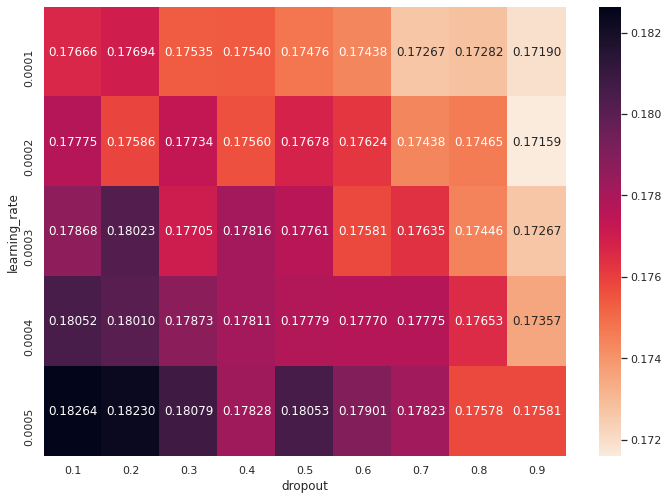

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

results_df = pd.DataFrame.from_records(results, columns=['learning_rate', 'dropout', 'loss'])
results_df = results_df.pivot("learning_rate", "dropout", "loss")
sns.heatmap(results_df, annot=True, fmt=".5f" ,cmap = sns.cm.rocket_r)

## Second Pass

In [ ]:
# SECOND ROUND OF GRID SEARCH (refined)
kf = StratifiedKFold(n_splits=5)
# HYPER PARAMETERS TUNING GRIDSEARCH
lrs = [0.000125, 0.00015, 0.000175, 0.0002, 0.000225]
dropouts = [0.86, 0.88, 0.9, 0.92, 0.94, 0.96]


results = []
for lr in lrs:
  for dropout in dropouts:
    losses = []
    for train_index, val_index in kf.split(X, y.argmax(1)):
      train_x_s, val_x_s = X[train_index], X[val_index]
      train_y_s, val_y_s = y[train_index], y[val_index]
      train_s_ds = tf.data.Dataset.from_tensor_slices((train_x_s, train_y_s))
      val_s_ds = tf.data.Dataset.from_tensor_slices((val_x_s, val_y_s))
      train_s_ds = prepare(train_s_ds, shuffle=True)
      val_s_ds = prepare(val_s_ds)

      lrr, EarlyStop = get_training_callbacks()

      model = get_model(train_x_s.shape[1], dropout, lr)

      #Training the model. 
      history = model.fit(train_s_ds,
                  validation_data=val_s_ds,
                  epochs=1000,
                  shuffle=True,
                  callbacks=[lrr,EarlyStop], verbose = 0)
      losses.append(model.evaluate(val_s_ds,verbose=0)[0])
    loss = sum(losses)/len(losses)
    print("LR: {} DROPOOUT: {} LOSS: {}".format(lr, dropout, loss))
    results.append((lr, dropout, loss))


LR: 0.000125 DROPOOUT: 0.86 LOSS: 0.17183800786733627
LR: 0.000125 DROPOOUT: 0.88 LOSS: 0.17256494909524916
LR: 0.000125 DROPOOUT: 0.9 LOSS: 0.17105579525232315
LR: 0.000125 DROPOOUT: 0.92 LOSS: 0.172640623152256
LR: 0.000125 DROPOOUT: 0.94 LOSS: 0.17301733940839767
LR: 0.000125 DROPOOUT: 0.96 LOSS: 0.1744410961866379
LR: 0.00015 DROPOOUT: 0.86 LOSS: 0.1716998815536499
LR: 0.00015 DROPOOUT: 0.88 LOSS: 0.17159922868013383
LR: 0.00015 DROPOOUT: 0.9 LOSS: 0.17019631415605546
LR: 0.00015 DROPOOUT: 0.92 LOSS: 0.17206415832042693
LR: 0.00015 DROPOOUT: 0.94 LOSS: 0.17264750003814697
LR: 0.00015 DROPOOUT: 0.96 LOSS: 0.17416891157627107
LR: 0.000175 DROPOOUT: 0.86 LOSS: 0.1711352363228798
LR: 0.000175 DROPOOUT: 0.88 LOSS: 0.1723620280623436
LR: 0.000175 DROPOOUT: 0.9 LOSS: 0.17200447469949723
LR: 0.000175 DROPOOUT: 0.92 LOSS: 0.17293979376554489
LR: 0.000175 DROPOOUT: 0.94 LOSS: 0.17200702726840972
LR: 0.000175 DROPOOUT: 0.96 LOSS: 0.17448968887329103
LR: 0.0002 DROPOOUT: 0.86 LOSS: 0.172135789

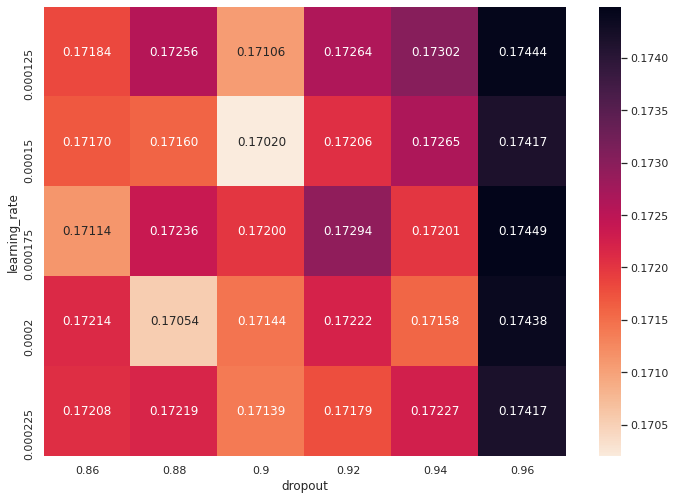

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

results_df = pd.DataFrame.from_records(results, columns=['learning_rate', 'dropout', 'loss'])
results_df = results_df.pivot("learning_rate", "dropout", "loss")
sns.heatmap(results_df, annot=True, fmt=".5f" ,cmap = sns.cm.rocket_r)

## Results
Best Results obtained when: dropout = 0.9, lr = 0.00015

In [ ]:
lr = 0.00015
dropout = 0.9

# Experiments on balancing dataset/ using class weights for imbalanced data

In [ ]:
# Base model
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1620 - accuracy: 0.9498


[0.16198480129241943, 0.9497717022895813]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

smotesampler = SMOTE(n_jobs=-1)
oversampler = RandomOverSampler()
undersampler = RandomUnderSampler()
ennsampler = EditedNearestNeighbours(n_jobs=-1)
smoteennsampler = SMOTEENN(smote=smotesampler, enn=ennsampler)


over_train_X, over_train_Y = oversampler.fit_resample(train_X, train_Y)
under_train_X, under_train_Y = undersampler.fit_resample(train_X, train_Y)
enn_train_X, enn_train_Y = ennsampler.fit_resample(train_X, train_Y)
smote_train_X, smote_train_Y = smotesampler.fit_resample(train_X, train_Y)
smoteen_train_X, smoteen_train_Y = smoteennsampler.fit_resample(train_X, train_Y)


over_train_ds = tf.data.Dataset.from_tensor_slices((over_train_X, over_train_Y))
over_train_ds = prepare(over_train_ds, shuffle=True)

under_train_ds = tf.data.Dataset.from_tensor_slices((under_train_X, under_train_Y))
under_train_ds = prepare(under_train_ds, shuffle=True)

enn_train_ds = tf.data.Dataset.from_tensor_slices((enn_train_X, enn_train_Y))
enn_train_ds = prepare(enn_train_ds, shuffle=True)

smote_train_ds = tf.data.Dataset.from_tensor_slices((smote_train_X, smote_train_Y))
smote_train_ds = prepare(smote_train_ds, shuffle=True)

smoteenn_train_ds = tf.data.Dataset.from_tensor_slices((smoteen_train_X, smoteen_train_Y))
smoteenn_train_ds = prepare(smoteenn_train_ds, shuffle=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# undersampled
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(under_train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.9478


[0.16902212798595428, 0.9478147625923157]

In [ ]:
# enn
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(enn_train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.2075 - accuracy: 0.9397


[0.20754337310791016, 0.9396607875823975]

In [ ]:
# oversampled
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(over_train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1627 - accuracy: 0.9494


[0.1626753956079483, 0.9494455456733704]

In [ ]:
# smote
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(smote_train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9494


[0.16118882596492767, 0.9494455456733704]

In [ ]:
# smoteenn
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(smoteenn_train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1776 - accuracy: 0.9465


[0.17759346961975098, 0.9465101361274719]

In [ ]:
# Class weights
lrr, EarlyStop = get_training_callbacks()
model = get_model(train_X.shape[1], dropout=dropout, lr=lr)


#Training the model. 
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=500,
            shuffle=True,
            class_weight=class_weights,
            callbacks=[lrr,EarlyStop], verbose = False)

model.evaluate(val_ds)

24/24 [==============================] - 0s 5ms/step - loss: 0.1615 - accuracy: 0.9498


[0.16152533888816833, 0.9497717022895813]

## Results
* Base: 0.1619
* RandomUndersampling: 0.1690
* ENN: 0.2075
* RandomOversampling: 0.1627
* SMOTE: 0.1612
* SMOTEENN: 0.1776
* Class Weights: 0.1615

In [ ]:
pred = tf.nn.softmax(model.predict(test_ds)).numpy()
preds_df = pd.DataFrame(columns=["id"] + list(classes))
test_path = "/content/data/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.loc[:,list(classes)]= pred
preds_df.to_csv('submission.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,2cc021273be838847ed66f9bafc21cca,1.5262e-06,7.279e-07,1.01956e-06,5.88533e-07,1.89498e-05,9.52065e-06,9.37685e-07,4.36598e-05,1.39094e-06,7.11464e-06,2.29637e-06,3.42072e-07,2.43016e-07,2.92012e-07,2.01646e-07,4.2219e-07,1.79624e-06,9.94079e-07,2.81091e-06,7.22589e-05,8.1976e-07,1.91085e-05,1.7947e-06,4.26125e-07,3.23483e-07,2.47196e-07,3.63339e-07,2.69814e-06,1.65832e-07,1.28361e-05,4.06671e-07,1.75018e-07,2.42951e-07,1.9315e-06,4.19448e-07,2.9825e-07,1.28451e-06,1.60386e-06,8.46206e-06,...,8.51211e-07,1.62252e-07,3.08783e-07,2.17688e-07,1.92729e-06,6.45485e-07,8.56698e-07,1.04807e-06,6.20826e-06,1.7804e-06,2.11109e-06,8.36859e-08,2.42771e-07,2.16781e-06,3.42201e-07,6.67959e-07,8.14958e-07,5.71364e-06,1.05772e-06,3.64767e-06,2.66245e-06,1.17292e-06,1.79595e-06,4.11571e-07,7.07838e-06,8.19695e-07,4.48084e-06,5.88881e-07,6.71607e-08,7.89779e-07,5.47275e-06,0.000234371,8.60393e-07,3.62905e-06,8.58214e-06,2.47944e-07,2.22288e-06,0.000559416,3.2994e-06,3.44938e-06
1,c88bbc39173d328c2db1afbc83b4a66f,1.96744e-05,2.45907e-06,3.3966e-06,5.99711e-07,5.66145e-06,2.14082e-06,7.54664e-06,1.98261e-06,1.01525e-06,1.85084e-06,7.85747e-07,1.92617e-06,2.25325e-06,6.09176e-06,5.47878e-07,2.39032e-06,8.29931e-05,2.24334e-06,2.28495e-06,2.07146e-06,5.25531e-06,3.18307e-06,7.43323e-06,3.13908e-06,2.57847e-06,8.89429e-07,2.83999e-06,1.15701e-06,8.45888e-07,0.000189975,2.07061e-05,2.2454e-06,1.03588e-05,1.3838e-05,1.30464e-06,9.6066e-07,1.48348e-05,2.77841e-06,5.32863e-06,...,3.38437e-06,6.8138e-06,6.10075e-07,1.01354e-06,0.00552668,0.000149119,7.10968e-06,0.991291,2.75273e-06,5.23865e-07,3.43794e-06,2.88717e-06,5.54571e-07,2.86736e-06,1.52122e-05,0.000148423,2.65493e-06,1.12795e-06,2.43274e-07,0.000417851,7.1144e-06,1.78042e-06,3.93638e-06,2.92564e-07,3.58501e-06,2.05754e-06,2.36498e-06,4.81199e-06,2.6135e-06,1.57519e-05,3.31323e-05,1.05893e-05,3.97613e-06,3.81683e-06,2.27304e-06,1.11897e-06,4.54935e-06,2.22471e-06,2.34562e-06,1.16639e-05
2,346ea95f3568247289cf02ebfd935e7f,5.07026e-06,2.80123e-05,1.75755e-05,2.08849e-06,6.72131e-06,4.98465e-06,2.00162e-06,6.25784e-07,1.58909e-06,1.1696e-06,2.25161e-06,3.03102e-06,1.85618e-06,5.344e-06,6.96215e-06,3.79801e-06,7.65604e-06,6.92287e-05,2.2745e-05,1.00067e-06,1.89997e-05,3.03174e-05,0.000116706,6.72583e-05,1.77613e-06,8.16716e-05,2.21566e-05,6.24172e-06,1.15669e-05,1.75268e-06,2.04516e-05,7.19904e-06,2.90937e-06,1.12402e-05,3.46259e-06,1.0265e-05,8.26879e-06,3.33123e-06,2.34314e-06,...,1.66021e-05,2.05771e-05,5.45366e-07,3.8683e-05,6.18527e-06,9.54086e-05,2.58437e-06,2.94902e-06,7.30082e-06,1.19847e-06,3.47296e-06,6.50734e-06,0.000158816,3.45949e-06,3.86424e-06,1.84971e-06,1.05756e-06,6.55677e-06,1.43091e-06,1.20006e-05,6.31439e-06,3.12508e-06,3.8359e-06,1.1425e-05,9.42448e-06,1.63096e-06,1.31482e-05,1.41802e-05,8.45348e-05,9.77984e-06,3.5372e-06,1.9806e-06,8.9851e-07,7.0907e-06,1.14585e-06,1.59966e-06,9.89891e-07

In [ ]:
!kaggle competitions submit -c dog-breed-identification -f submission.csv -m "Class Weighted"

100% 26.8M/26.8M [00:00<00:00, 42.2MB/s]
Successfully submitted to Dog Breed Identification